In [105]:
import warnings
warnings.filterwarnings('ignore')
import torch
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from torch import optim
import  torch.nn.functional as F

In [6]:
df = pd.read_csv('upa_event_ts.csv')
df = df.sort_values(by=['datetime'])

In [11]:
def get_ts(code,df, apply_box_cox = True, lamb = 0.5):
    values = np.float32(df[df.code == code]['count'].values)
    dim = values.shape[0]
    index = np.int64(np.array([x for x in range(1,dim+1)]))
    index = index.ravel()
    values = values.ravel()
    if (apply_box_cox):
        values = boxcox(values, lamb)
    return (index, values)

In [207]:
LEARNING_RATE = 1.0
PERIOD = 1008
PI = np.pi
ALPHA_REG = 0
THRESHOLD = 950
TEST = 144*4  #For the las 4 days

In [251]:
x_ts_tran, y_ts_tran = get_ts('activities-checkout',df, apply_box_cox=True, lamb=0.5)
#For train everything except the last four days
x_ts_train = x_ts_tran[:-TEST]
y_ts_train = y_ts_tran[:-TEST]

# *Modelo de Fourier (para series de tiempo periodicas)*

## $S_{t} = \sum_{k = 1}^{N-1} A_{k}\sin(\frac{2k\pi t}{N}) + \sum_{k = 1}^{N-1} B_{k}\cos(\frac{2k\pi t}{N}) $

### Tambien es posible expresarlo solo con senos poniendo un parametro mas que es la fase
## $S_{t} = \sum_{k = 1}^{N-1} A_{k}\sin(\frac{2k\pi t}{N} + P_{k}) $

### Donde $N$ es la cantidad de mediciones por ciclo de la serie de tiempo. $A_{k}$ y $B_{k}$ son las amplitudes y los parametros en este modelo. En nuestro caso las series de tiempo de upa por lo general tienen dos estacionalidades una diaria y otra semanal. Para poder capturar los dos tipos de estacionalidad $N$ tiene que contemplar la cantidad de mediciones por semana.

### La solucion que proponemos es usar *descenso por el gradiente* para encontrar los parametros optimos usando como funcion objetivo MSE entre el valor de la serie de tiempo y el calculado por el modelo.

### Observamos que el tiempo de entrenamiento es mucho menor si aplicamos la trasnformacion de box-cox a la serie de tiempo ya que esta disminuye ruido de la serie y no perjudica el calculo de las anomalias, es decir las anomalias siguen existiendo en la serie transformada.

### La transformacion de box-cox esta dada por la siguiente ecuacion:

## $ \displaystyle{X}_{\lambda}^{'} = \frac{{X}^{\lambda} - 1}{\lambda}$ 
### Para el caso de $\lambda = 0$ resulta en $log$

## *Armado del grafo en tensorflow y optimizacion de parametros*

In [252]:
x_train = torch.tensor(x_ts_train, dtype = torch.float32, requires_grad=False)

In [253]:
y_train = torch.tensor(y_ts_train,dtype = torch.float32, requires_grad=False)

In [254]:
class FourierModel(torch.nn.Module):
    def __init__(self):
        super(FourierModel, self).__init__()
        self.multipliers = torch.tensor([(x*2*PI)/PERIOD for x in range(THRESHOLD,PERIOD)], dtype=torch.float32, requires_grad=False)
        self.amplitudes_cos = torch.rand(1, PERIOD - THRESHOLD, requires_grad=True)
        self.phases = torch.rand(1, PERIOD - THRESHOLD, requires_grad = True)
        self.amplitudes_sin = torch.rand(1, PERIOD - THRESHOLD, requires_grad= True)
        self.bias = torch.zeros(1, requires_grad=True)
        
    def parameters(self):
        return [self.amplitudes_sin, self.amplitudes_cos, self.phases, self.bias]
        
    def forward(self, x):
        sin_part = torch.sum(torch.sin(x.view(-1, 1) * self.multipliers) * self.amplitudes_sin, dim=1)
        cos_part = torch.sum(torch.cos(x.view(-1, 1) * self.multipliers) * self.amplitudes_cos, dim=1)
        return sin_part + cos_part + self.bias

In [255]:
model = FourierModel()

In [256]:
optimizer = optim.Adam(model.parameters(), lr=0.5)

In [257]:
epochs = 400

for i in range(epochs):
    optimizer.zero_grad()
    y_pred = model.forward(x_train)
    loss = F.mse_loss(y_train, y_pred)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print("epoch %s, mse = %s " % (i, loss.item()))

epoch 0, mse = 356.09466552734375 
epoch 10, mse = 140.4679718017578 
epoch 20, mse = 59.235496520996094 
epoch 30, mse = 20.329923629760742 
epoch 40, mse = 8.589143753051758 
epoch 50, mse = 7.771132469177246 
epoch 60, mse = 7.987109184265137 
epoch 70, mse = 7.707997798919678 
epoch 80, mse = 7.471965789794922 
epoch 90, mse = 7.413295745849609 
epoch 100, mse = 7.419322490692139 
epoch 110, mse = 7.415930271148682 
epoch 120, mse = 7.411803245544434 
epoch 130, mse = 7.4112229347229 
epoch 140, mse = 7.41130256652832 
epoch 150, mse = 7.411181449890137 
epoch 160, mse = 7.411120891571045 
epoch 170, mse = 7.411123275756836 
epoch 180, mse = 7.411120414733887 
epoch 190, mse = 7.4111175537109375 
epoch 200, mse = 7.411118030548096 
epoch 210, mse = 7.411118984222412 
epoch 220, mse = 7.411118030548096 
epoch 230, mse = 7.411118984222412 
epoch 240, mse = 7.411118030548096 
epoch 250, mse = 7.411118984222412 
epoch 260, mse = 7.411118030548096 
epoch 270, mse = 7.411118984222412 
ep

## *Calculo del ruido*

In [258]:
y_p = model.forward(x_train).detach().numpy()
noise = y_ts_train - y_p

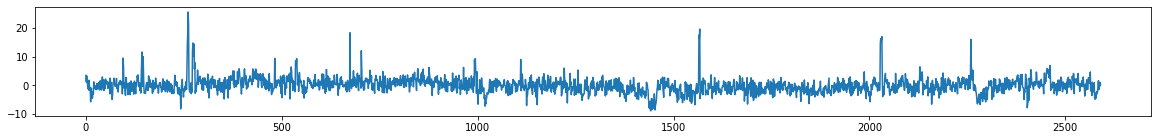

In [259]:
plt.figure(figsize=(20,2))
sbn.lineplot(list(range(len(noise))), noise)

## *Calculo de anomalias*

In [260]:
sigma = np.sqrt(np.var(y_ts_train - y_p))

In [261]:
anomalies_index = np.argwhere(np.abs(noise) - 2.2*sigma > 0)

## *Anomalias sobre la serie con la transformacion box-cox*

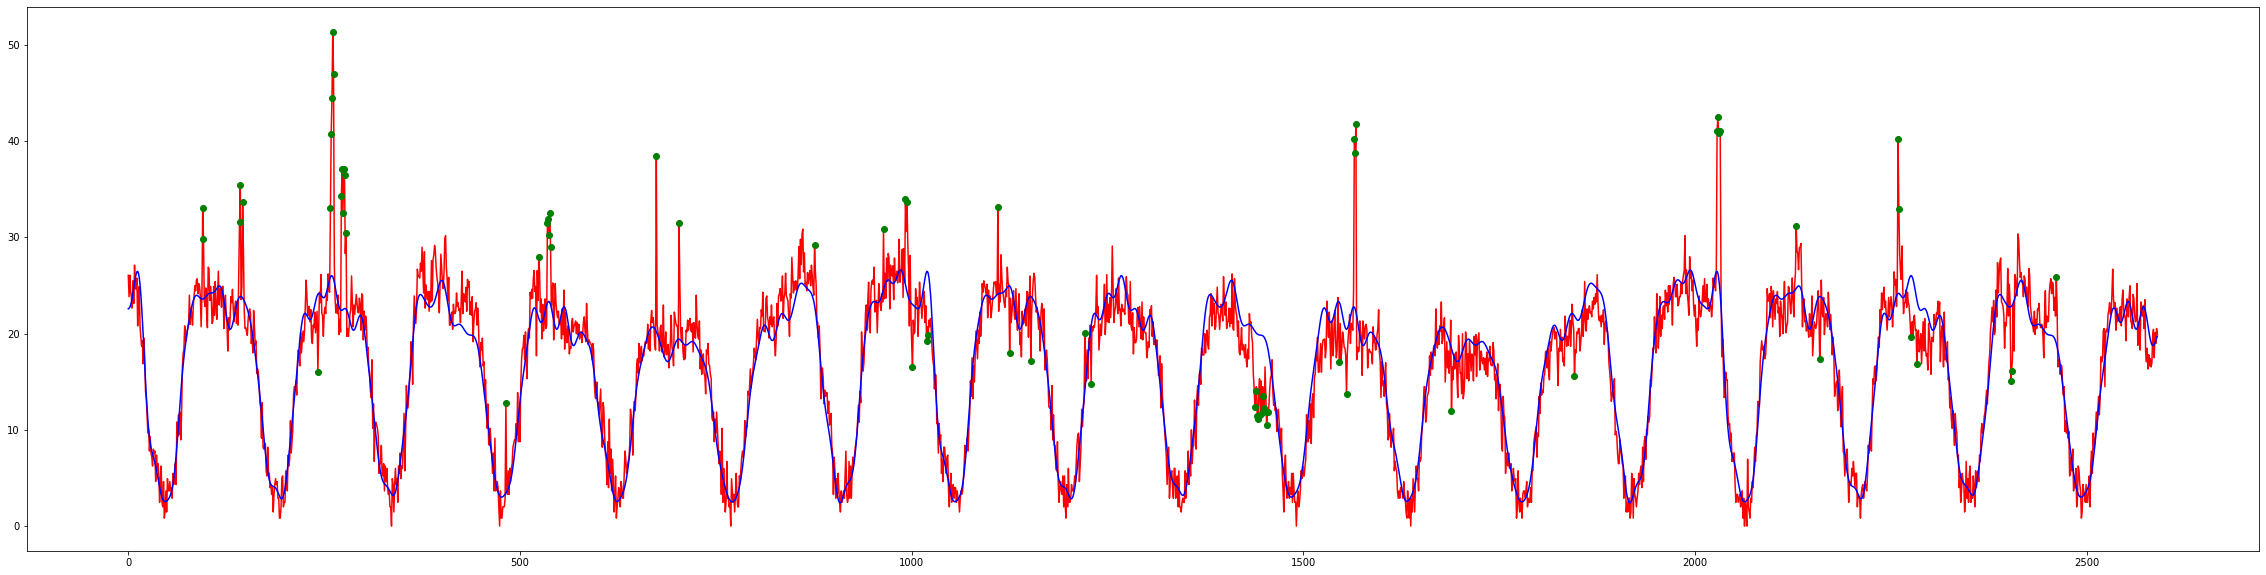

In [262]:
plt.figure(figsize=(40,10))
plt.plot(y_ts_train,"-r")
plt.plot(y_p, "-b")
plt.plot(anomalies_index, y_ts_train[anomalies_index], "og")

## *Anomalias sobre la serie original mostrando los indices de la serie con box-cox*

In [242]:
x_ts, y_ts = get_ts('activities-checkout',df, apply_box_cox=False, lamb=0.5)
#For train everything except the last four days
x_ts_train = x_ts[:-TEST]
y_ts_train = y_ts[:-TEST]

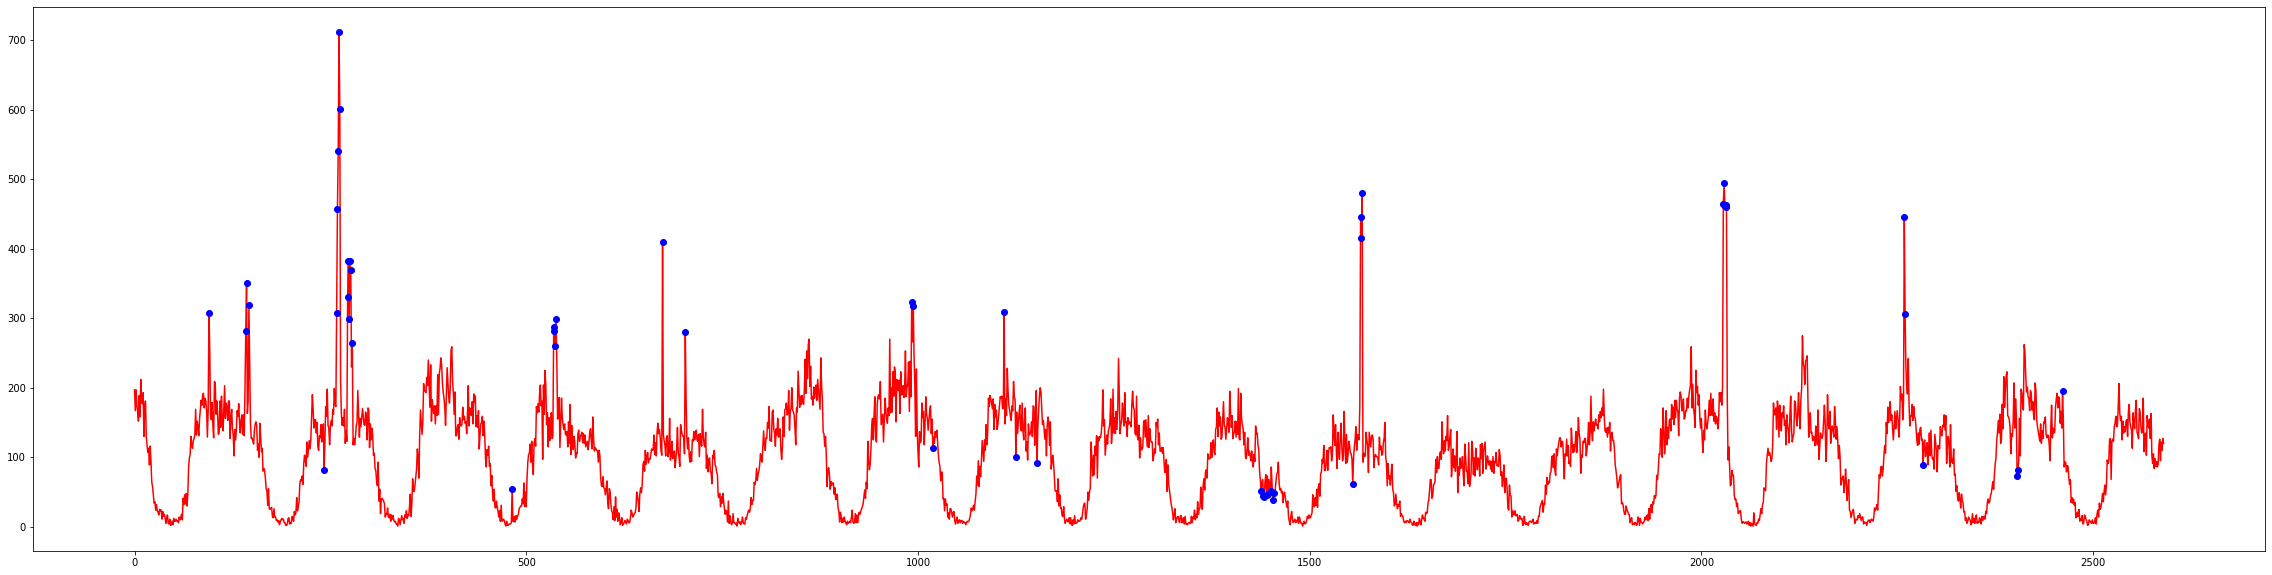

In [245]:
plt.figure(figsize=(40,10))
plt.plot(y_ts_train,"-r")
plt.plot(anomalies_index, y_ts_train[anomalies_index], "ob")